In [1]:
%matplotlib inline

In [2]:
import zipfile
# This is used to load models train on kaggle
with zipfile.ZipFile("../data/models/unet-ssim-loss.zip", 'r') as zip_ref:
   zip_ref.extractall("../data/models")

In [3]:
from src.ptp.globals import TARGET_DATA_DIR, TRAINING_DIR
import os 
import torch
import nibabel as nib  
from monai.data import MetaTensor
import torch.nn.functional as F
from skimage.metrics import structural_similarity
from lightning.pytorch.loggers import WandbLogger
import wandb 

from src.ptp.models.u_net.u_net import Net
import pytorch_lightning as pl 

from pathlib import Path
from src.ptp.evaluation.visualization import visualize_slices, visualize_volumes
from src.ptp.models.transforms import CorruptedTransform, rescale_volume, RescaleTransform
from src.ptp.utils import training_data_generator
import matplotlib.pyplot as plt

import numpy as np
import os

In [4]:
wandb.login(key=os.getenv('WANDA_API_KEY'))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 266564 (farqlia-266564). Use `wandb login --relogin` to force relogin


True

In [5]:
os.listdir(TARGET_DATA_DIR)

['seismicCubes_RFC_fullstack_2023.76346555.nii',
 'seismicCubes_RFC_fullstack_2023.76346557.nii']

In [6]:
corrupted_tf = CorruptedTransform(10, keys=['target'])

target_file = os.listdir(TARGET_DATA_DIR)[0]
target = nib.load(TARGET_DATA_DIR / target_file).get_fdata()

target = MetaTensor(torch.unsqueeze(torch.Tensor(target), 0))
print(target.shape)

data = corrupted_tf({'target': target})

torch.Size([1, 300, 300, 1259])


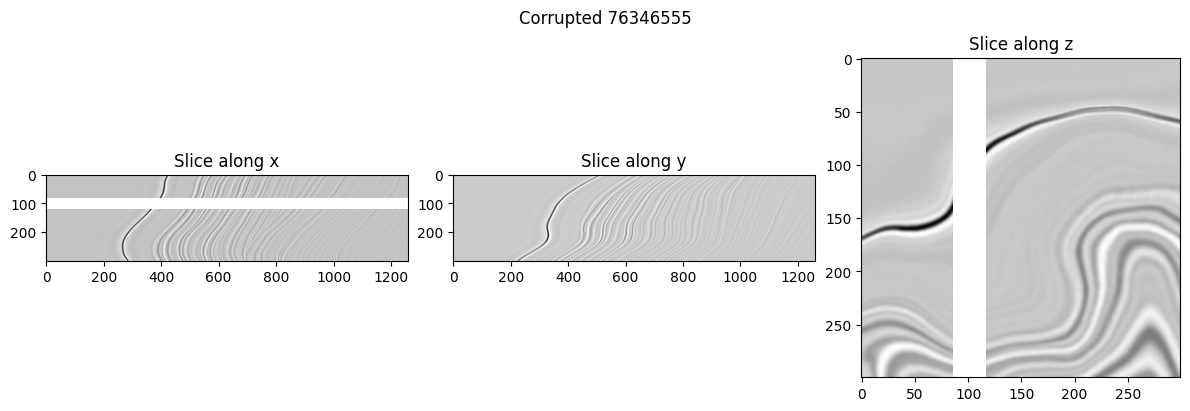

In [7]:
visualize_slices(nib.Nifti1Image(data['image'].as_tensor().numpy()[0], np.eye(4)), 150, 150, 400, f'Corrupted {target_file.split(".")[-2]}')

#### How original and training images differ

Original and corrupted images have different intensities because the later is scaled to some range - thus the same scaling will be applied to the original image

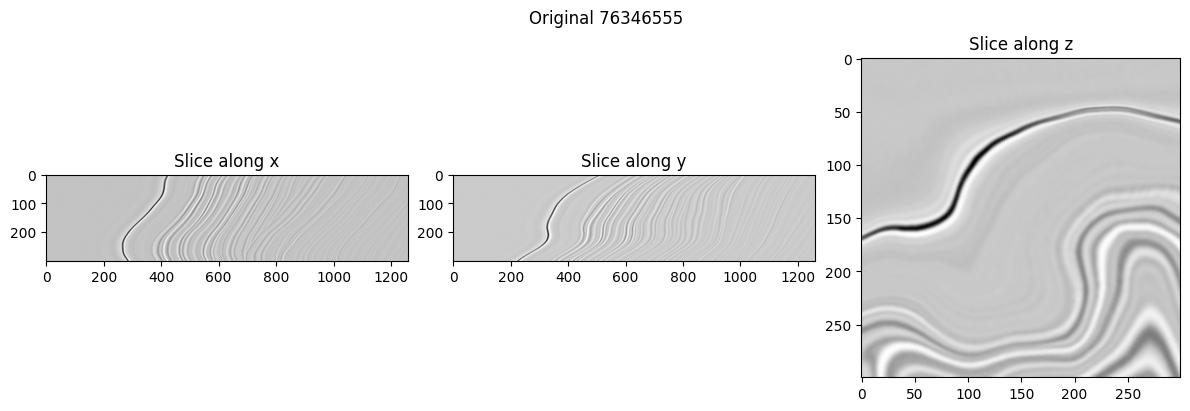

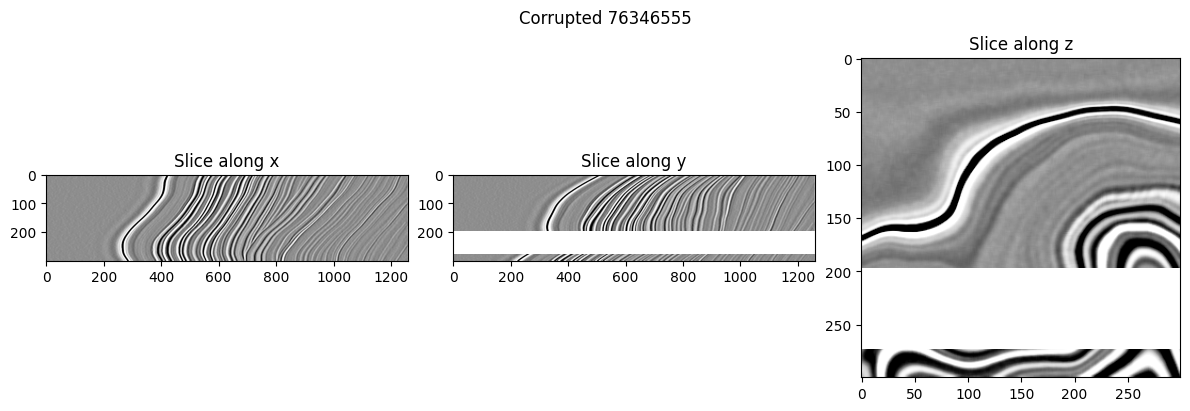

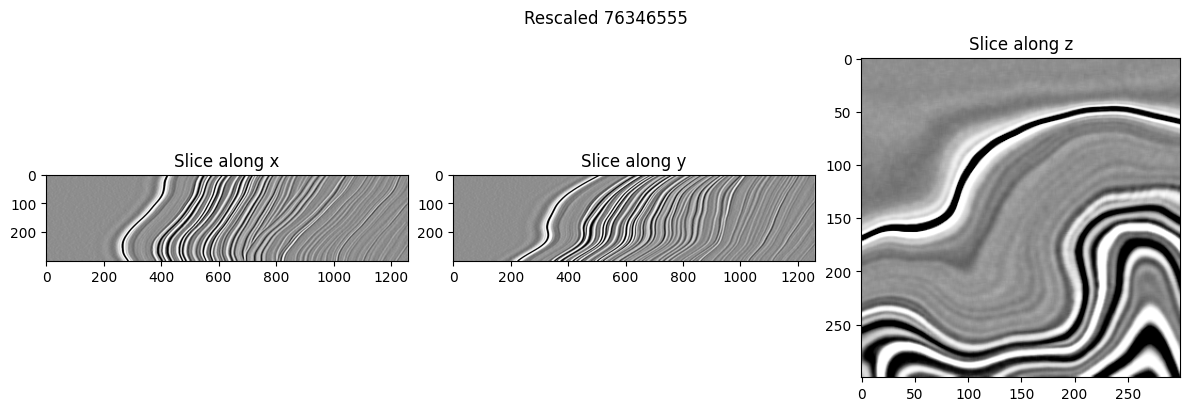

In [8]:
target_file = os.listdir(TARGET_DATA_DIR)[0]
target = nib.load(TARGET_DATA_DIR / target_file)
visualize_slices(target, 150, 150, 400, f'Original {target_file.split(".")[-2]}')
img, _, _ = training_data_generator(target.get_fdata())
target = rescale_volume(target.get_fdata())
visualize_slices(nib.Nifti1Image(img, np.eye(4)), 150, 150, 400, f'Corrupted {target_file.split(".")[-2]}')
visualize_slices(nib.Nifti1Image(target, np.eye(4)), 150, 150, 400, f'Rescaled {target_file.split(".")[-2]}')

In [10]:
net = Net(percentile=5, target_data_dir=TARGET_DATA_DIR)

net.prepare_data()

In [11]:
dataiter = iter(net.train_data)

In [12]:
sample = next(dataiter)

In [13]:
sample.keys()

dict_keys(['target', 'image', 'mask'])

Images are cropped because they can't fit into the memory

In [14]:
sample['image'].shape

torch.Size([1, 256, 256, 256])

In [15]:
original_pt = sample['target'].as_tensor()[0]
corrupted_pt = sample['image'].as_tensor()[0]

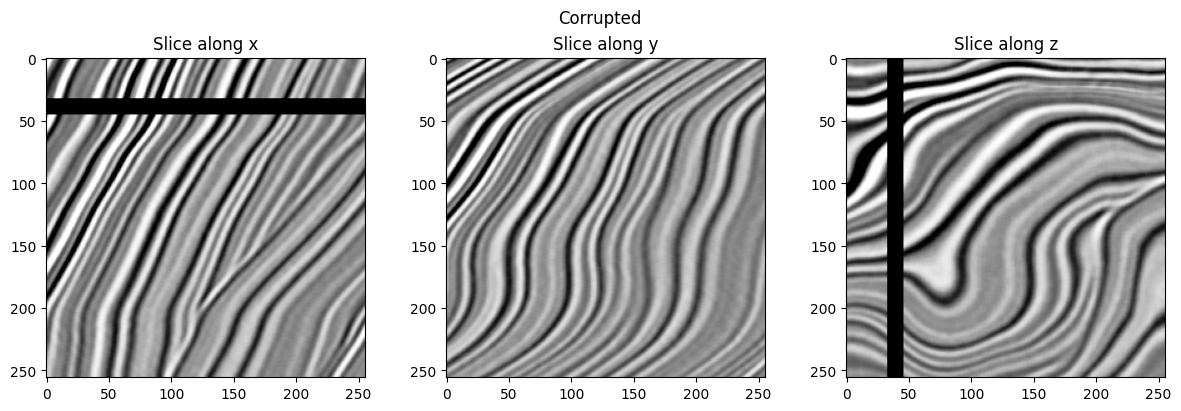

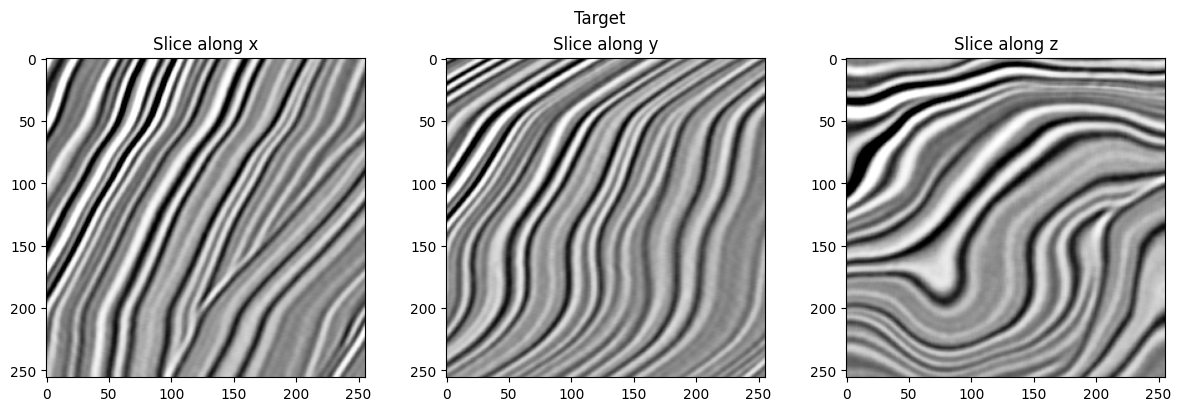

In [16]:
visualize_slices(nib.Nifti1Image(corrupted_pt.numpy(), np.eye(4)), 100, 150, 100, 'Corrupted')
visualize_slices(nib.Nifti1Image(original_pt.numpy(), np.eye(4)), 100, 150, 100, 'Target')

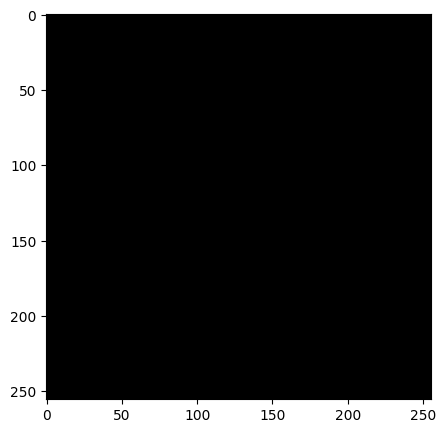

In [17]:
plt.figure(figsize=(5, 5))
plt.imshow(sample['mask'].numpy()[0, :, 100, :], cmap='gray')

In [18]:
corrupted_pt.numpy()[100, :, :]

array([[0.10075431, 0.        , 0.        , ..., 0.265625  , 0.21982759,
        0.22211745],
       [0.        , 0.        , 0.        , ..., 0.24501617, 0.21524785,
        0.23814654],
       [0.        , 0.        , 0.        , ..., 0.24043642, 0.23127693,
        0.2724946 ],
       ...,
       [0.30684268, 0.2885237 , 0.3045528 , ..., 0.54956895, 0.55414873,
        0.54269934],
       [0.3137123 , 0.29310346, 0.30913252, ..., 0.5404095 , 0.54269934,
        0.53125   ],
       [0.30913252, 0.2885237 , 0.30226293, ..., 0.53811955, 0.5335399 ,
        0.5220905 ]], dtype=float32)

In [19]:
original_pt.numpy()[100, :, :]

array([[0.10114942, 0.        , 0.        , ..., 0.26666668, 0.22068965,
        0.2229885 ],
       [0.        , 0.        , 0.        , ..., 0.24597701, 0.21609196,
        0.23908046],
       [0.        , 0.        , 0.        , ..., 0.2413793 , 0.2321839 ,
        0.2735632 ],
       ...,
       [0.30804598, 0.28965518, 0.30574712, ..., 0.55172414, 0.55632186,
        0.5448276 ],
       [0.31494254, 0.29425287, 0.31034482, ..., 0.54252875, 0.5448276 ,
        0.53333336],
       [0.31034482, 0.28965518, 0.3034483 , ..., 0.54022986, 0.5356322 ,
        0.5241379 ]], dtype=float32)

In [20]:
structural_similarity(corrupted_pt.numpy()[100, :, :], original_pt.numpy()[100, :, :], data_range=1.0)

0.9396261018006394

In [21]:
F.mse_loss(corrupted_pt[100, :, :], original_pt[100, :, :])

tensor(0.0151)

In [22]:
output = net(torch.unsqueeze(sample['image'], 0))

In [23]:
output.shape

torch.Size([1, 1, 256, 256, 256])

In [24]:
F.mse_loss(sample['target'], output)

Using a target size (torch.Size([1, 1, 256, 256, 256])) that is different to the input size (torch.Size([1, 256, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


metatensor(0.5884, grad_fn=<AliasBackward0>)

In [25]:
sample['mask'].shape

torch.Size([1, 256, 256, 256])

In [26]:
masked_target = sample['target'] * sample['mask']

In [27]:
masked_target.max()

metatensor(1.)

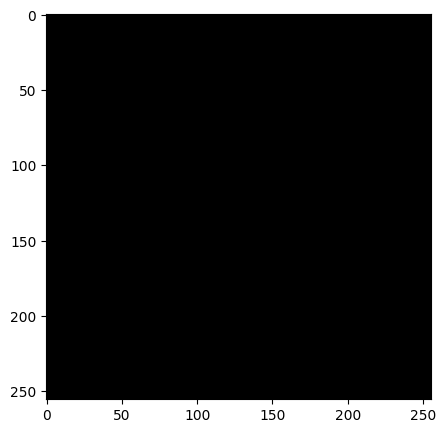

In [28]:
plt.figure(figsize=(5, 5))
plt.imshow(masked_target.numpy()[0, :, 200, :], cmap='gray')

In [29]:
sample['mask'].type(torch.bool)

tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False,

In [30]:
nonzero_mask = torch.nonzero(masked_target).numpy()

In [31]:
nonzero_mask.shape

(828771, 4)

In [32]:
random_slice = nonzero_mask[np.random.randint(0, nonzero_mask.shape[0])]
_, x, y, z = random_slice
print(random_slice)

[ 0 43 44  9]


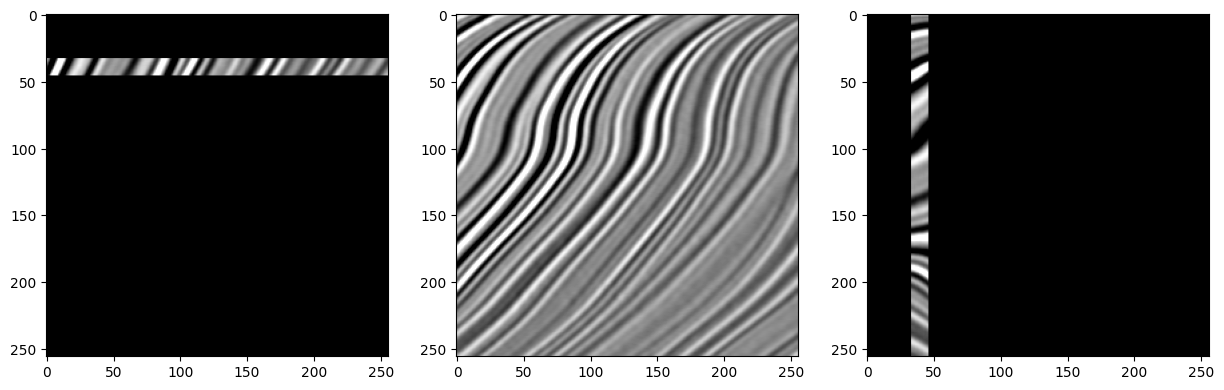

In [33]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
plt.imshow(masked_target[0, x, :, :], cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(masked_target[0, :, y, :], cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(masked_target[0, :, :, z], cmap='gray')

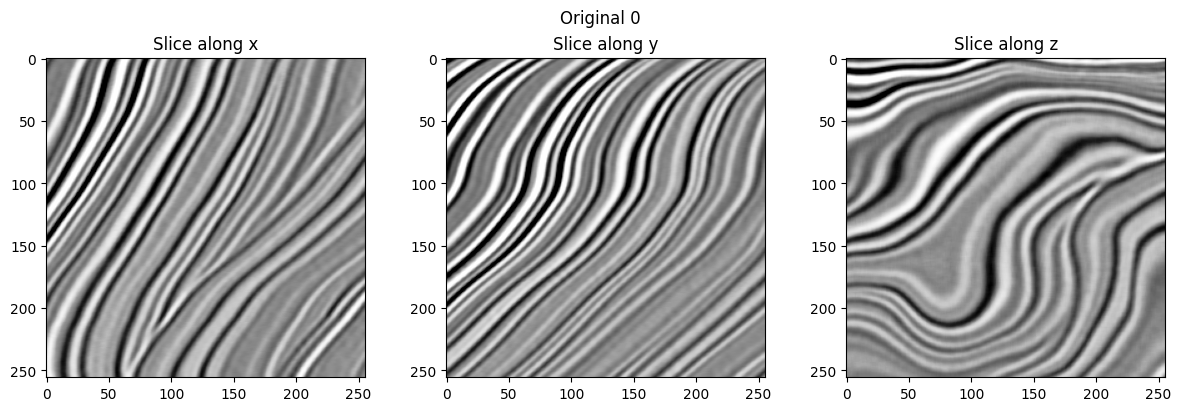

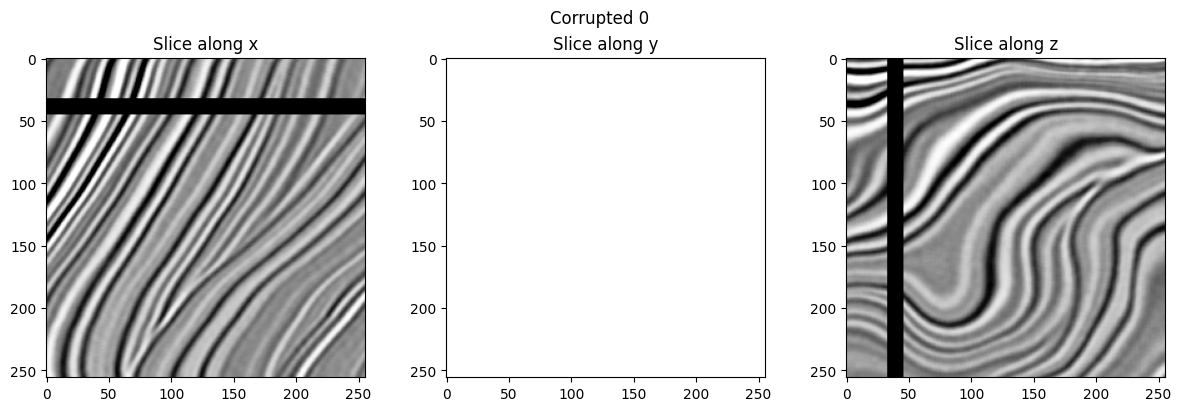

In [34]:
visualize_volumes(sample, 0, ['target', 'image'], ['Original', 'Corrupted'])

#### Problems
1. The whole volume can't fit into the memory
2. U-Net imposes constraints on the sizes of the volumes because of the down and up samplings

https://github.com/Project-MONAI/tutorials/blob/main/modules/UNet_input_size_constraints.ipynb

In [35]:
from torchmetrics.functional.image import structural_similarity_index_measure

def ssim_loss(preds, target):
    return 1 - structural_similarity_index_measure(preds, target, data_range=1.0)

In [36]:
wandb_logger = WandbLogger(project="U-NET-PTP")

In [38]:
max_epochs = 20
percentile = 5

checkpoint_dir = Path(TRAINING_DIR / 'unet-8-mse')

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=checkpoint_dir, filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', monitor='val_loss', save_last=True) 
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)
 
net = Net(percentile=percentile, 
          target_data_dir=TARGET_DATA_DIR, 
          loss_func=F.mse_loss)

trainer = pl.Trainer(
    max_epochs=max_epochs,
    default_root_dir=checkpoint_dir,
    callbacks=[checkpoint_callback],
    fast_dev_run=True, num_sanity_val_steps=0,
    logger=wandb_logger
)

trainer.fit(net)
wandb.finish()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
C:\Users\julia\anaconda3\envs\ptp\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory C:\Users\julia\PycharmProjects\SOLVRO-PTP2\data\training\unet-8-mse exists and is not empty.

  | Name   | Type | Params
--------------------------------
0 | _model | UNet | 4.8 M 
--------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.232    Total estimated model params size (MB)
C:\Users\julia\anaconda3\envs\ptp\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
C:\Users\julia\anaconda3\envs\ptp\li

Epoch 0: 100%|██████████| 1/1 [00:40<00:00,  0.02it/s, train_loss_step=0.598]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 1/1 [01:04<00:00,  0.02it/s, train_loss_step=0.598, val_loss=0.344, train_loss_epoch=0.598]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|██████████| 1/1 [01:04<00:00,  0.02it/s, train_loss_step=0.598, val_loss=0.344, train_loss_epoch=0.598]


#### Predictions with MSE Loss

In [12]:
os.listdir(TRAINING_DIR / 'unet-8-mse')

['epoch=0-val_loss=0.27-train_loss=0.96.ckpt',
 'epoch=0-val_loss=0.38-train_loss=0.96.ckpt',
 'epoch=9-val_loss=0.16-train_loss=0.26.ckpt',
 'last-v1.ckpt',
 'last-v2.ckpt',
 'last.ckpt',
 'lightning_logs']

In [13]:
net = Net.load_from_checkpoint(TRAINING_DIR / 'unet-8-mse/epoch=9-val_loss=0.16-train_loss=0.26.ckpt', percentile=percentile)

net.eval()
net.prepare_data()
val_loader = net.val_dataloader()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


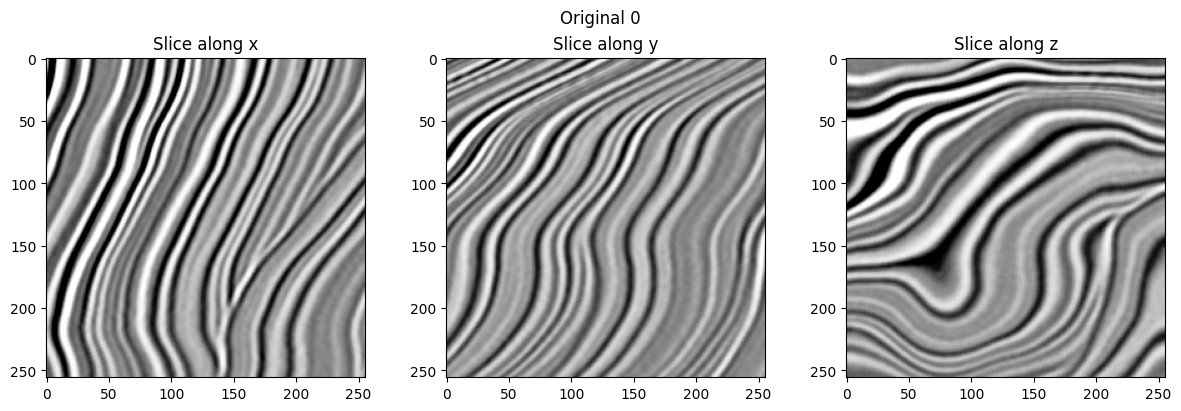

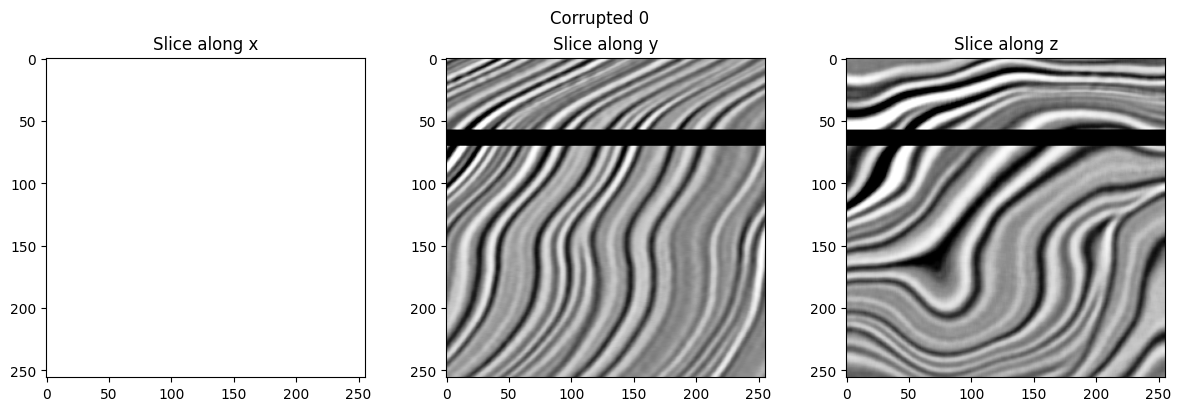

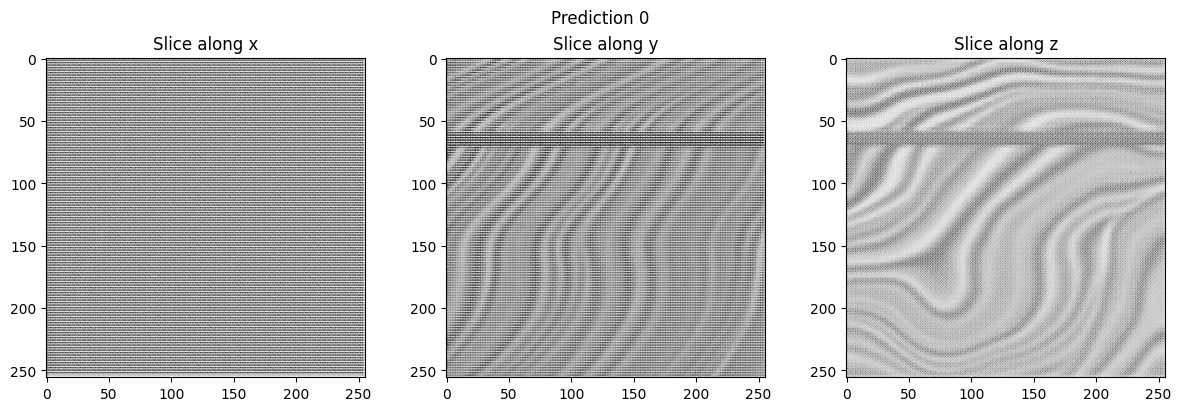

In [14]:
keys = ['target','image', 'prediction']
labels = ['Original','Corrupted', 'Prediction']

trainer = pl.Trainer()

for i, batch in enumerate(val_loader):
    prediction = net(batch['image'])
    batch['prediction'] = prediction
    visualize_volumes(batch, i, keys, labels, True)

#### Predictions with SSIM Loss

In [39]:
os.listdir(TRAINING_DIR / 'unet-8-ssim')

['epoch=4-val_loss=0.98-train_loss=0.94.ckpt', 'last.ckpt', 'lightning_logs']

In [41]:
net = Net.load_from_checkpoint(TRAINING_DIR / 'unet-8-ssim/epoch=4-val_loss=0.98-train_loss=0.94.ckpt', 
                               target_data_dir=TARGET_DATA_DIR, percentile=percentile)

net.eval()
net.prepare_data()
val_loader = net.val_dataloader()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


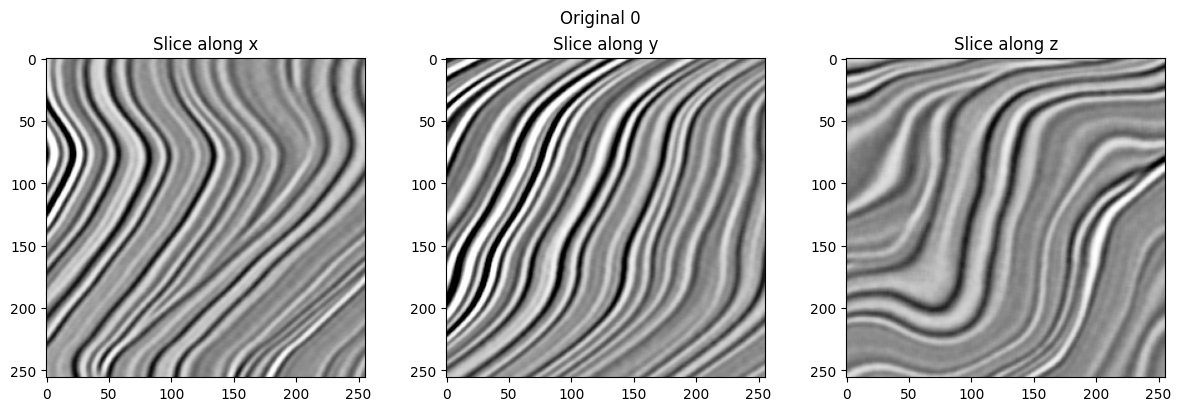

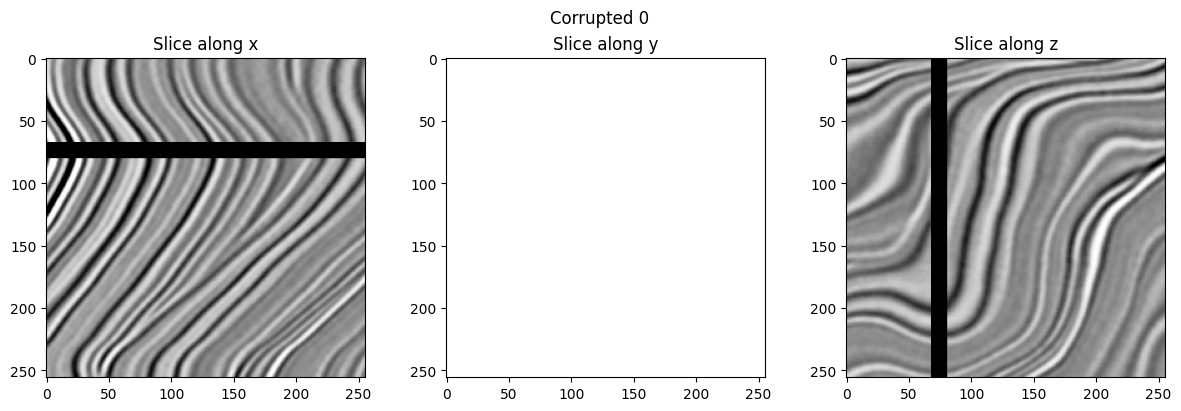

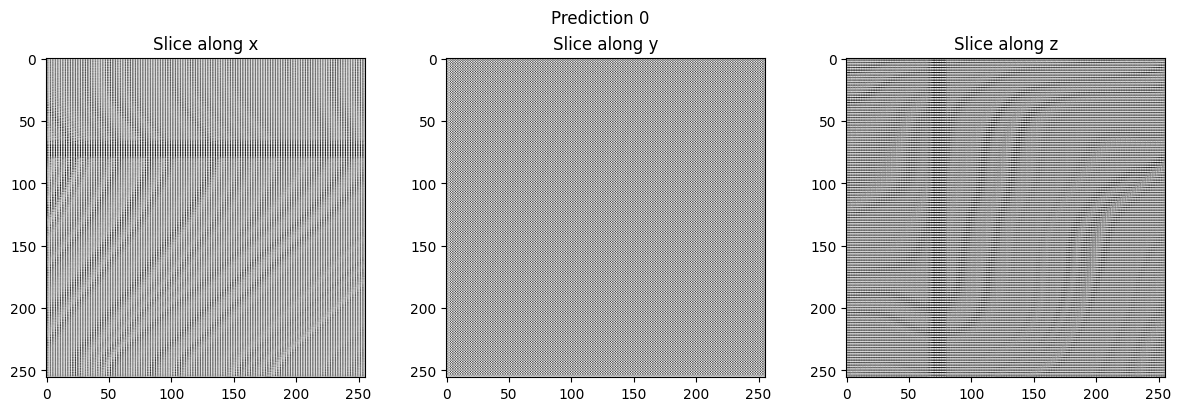

In [42]:
keys = ['target','image', 'prediction']
labels = ['Original','Corrupted', 'Prediction']

trainer = pl.Trainer()

for i, batch in enumerate(val_loader):
    prediction = net(batch['image'])
    batch['prediction'] = prediction
    visualize_volumes(batch, i, keys, labels, True)